
## Ejercicio 3

Para resolver este ejercicio utilice un modelo de red neuronal convolucional que reconozca la cantidad de dedos extendidos en cada mano de las imágenes del dataset **“Fingers”**.

<div style="text-align: center;">
    <img src='../../images/p4-ej10.png' width="40%">
</div>

La versión original de este de estas imágenes se encuentra en https://www.kaggle.com/koryakinp/fingers.

Puede hallar una versión reducida de estas imágenes en el Moodle del curso, en la misma sección donde se encuentra este enunciado de práctica. También encontrará allí ejemplos sobre cómo cargar estas imágenes y cómo procesarlas con una red neuronal convolucional.

### a)

Entrene y pruebe un modelo utilizando los datos de las carpetas **test** y **train**, midiendo **accuracy**.

#### Cargar datos

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
import glob

# Definir rutas
TRAIN_DIR = '../../Datos/fingers/train'
TEST_DIR = '../../Datos/fingers/test'

IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

def import_data(data_dir):

    img_list = glob.glob(data_dir)      # Obtener la lista de archivos de imágenes

    assert len(img_list) > 0, IMG_ERROR # verifica que la ruta sea correcta y tenga al menos 1 imagen

    img_data = []  # lista de imagenes
    lbl_data = []  # lista de etiquetas

    img_count = len(img_list)
    for i, img_path in enumerate(img_list):

        img = Image.open(img_path)          # Carga imagen
        img = np.array(img) / np.max(img)   # Normaliza los píxeles entre 0 y 1
        img = img.reshape((*img.shape, 1))  # Formatea la imagen para TF: WxH => WxHx1

        # Almacenar la imagen y la etiqueta
        img_data.append(img)
        # ej. nombre de archivo: 000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png
        lbl_data.append(int(img_path[-6]))  # Extrae la cantidad de dedos del nombre del archivo

        # Mostrar progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100 * i / img_count), end="")

    print("\rCargando imágenes: 100.00%% (%d) \n" % img_count)

    return np.array(img_data), np.array(lbl_data)


x_train, y_train = import_data(TRAIN_DIR+"/*/*.png")
x_test, y_test = import_data(TEST_DIR+"/*/*.png")
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.30, shuffle = True)

Cargando imágenes: 100.00% (17999) 

Cargando imágenes: 100.00% (3600) 



#### Entrenar modelo

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, LeakyReLU
from tensorflow.keras import optimizers, callbacks
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def entrenar_modelo_cnn(x_train, y_train, x_test, y_test, titulo="Entrenamiento"):
    """
    Entrena un modelo CNN con los datos proporcionados
    
    Args:
        x_train, y_train: datos de entrenamiento
        x_test, y_test: datos de prueba
        titulo: título para los gráficos
    
    Returns:
        model, history: modelo entrenado e historial
    """
    
    # División train/validation
    x_train_split, x_val, y_train_split, y_val = train_test_split(
        x_train, y_train, test_size=0.30, shuffle=True
    )
    
    # Parámetros del modelo
    EPOCAS = 100
    LOTES = 128
    PACIENCIA = 5
    IMG_SIZE = x_train.shape[1:]
    N_CLASSES = len(np.unique(y_train))
    ACTIVA = LeakyReLU()
    
    print(f"Entrenando modelo con {len(x_train)} imágenes")
    print(f"Forma de imagen: {IMG_SIZE}, Clases: {N_CLASSES}")
    
    # Construir el modelo
    model = Sequential()
    model.add(Input(shape=IMG_SIZE))
    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(32, activation=ACTIVA))
    model.add(Dense(N_CLASSES, activation='softmax'))
    
    # Compilar modelo
    optimizer = optimizers.Adam(0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Parada temprana
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, min_delta=0.001, restore_best_weights=True)
    
    # Entrenar modelo
    H = model.fit(
        x_train_split, y_train_split,
        batch_size=LOTES,
        epochs=EPOCAS,
        validation_data=(x_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluar modelo
    pred_train = model.evaluate(x_train_split, y_train_split, verbose=0)
    pred_val = model.evaluate(x_val, y_val, verbose=0)
    pred_test = model.evaluate(x_test, y_test, verbose=0)
    
    print(f"\nResultados del {titulo}:")
    print(f"Efectividad entrenamiento: {pred_train[1]*100:.2f}%%")
    print(f"Efectividad validación...: {pred_val[1]*100:.2f}%%")
    print(f"Efectividad prueba.......: {pred_test[1]*100:.2f}%%")
    
    # Gráficos de entrenamiento
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Pérdida", "Precisión"))
    
    fig.add_trace(go.Scatter(y=H.history["loss"], mode='lines', name='train_loss'), row=1, col=1)
    fig.add_trace(go.Scatter(y=H.history["val_loss"], mode='lines', name='val_loss'), row=1, col=1)
    
    fig.add_trace(go.Scatter(y=H.history["accuracy"], mode='lines', name='train_acc'), row=1, col=2)
    fig.add_trace(go.Scatter(y=H.history["val_accuracy"], mode='lines', name='val_acc'), row=1, col=2)
    
    fig.update_layout(
        title=f"{titulo} - Métricas de Entrenamiento",
        xaxis_title="Época",
        yaxis_title="Valor",
        legend_title="Métricas",
        width=1200,
        height=600,
        template="plotly_white"
    )
    
    fig.show()
    
    return model, H

# Uso de las funciones:

# 1. Entrenar con datos originales
print("=== ENTRENAMIENTO CON DATOS ORIGINALES ===")
model_original, history_original = entrenar_modelo_cnn(
    x_train, y_train, x_test, y_test, 
    titulo="Datos Originales"
)

=== ENTRENAMIENTO CON DATOS ORIGINALES ===
Entrenando modelo con 12599 imágenes
Forma de imagen: (64, 64, 1), Clases: 6

Resultados del Datos Originales:
Efectividad entrenamiento: 100.00%%
Efectividad validación...: 99.97%%
Efectividad prueba.......: 99.86%%


#### Evaluación del modelo

### b)

Genere una versión del **dataset** para **test** agregando transformaciones al azar sobre imágenes originales. Haga **rotaciones** entre -45° y 45°, repita el test y mida el accuracy.

Efectividad del modelo con datos de Prueba rotado -45 grados:  40.92%
Efectividad del modelo con datos de Prueba rotado -40 grados:  43.17%
Efectividad del modelo con datos de Prueba rotado -35 grados:  45.86%
Efectividad del modelo con datos de Prueba rotado -30 grados:  49.42%
Efectividad del modelo con datos de Prueba rotado -25 grados:  60.14%
Efectividad del modelo con datos de Prueba rotado -20 grados:  68.17%
Efectividad del modelo con datos de Prueba rotado -15 grados:  79.44%
Efectividad del modelo con datos de Prueba rotado -10 grados:  91.83%
Efectividad del modelo con datos de Prueba rotado  -5 grados:  98.94%
Efectividad del modelo con datos de Prueba rotado   0 grados:  99.86%
Efectividad del modelo con datos de Prueba rotado   5 grados:  98.89%
Efectividad del modelo con datos de Prueba rotado  10 grados:  91.47%
Efectividad del modelo con datos de Prueba rotado  15 grados:  78.56%
Efectividad del modelo con datos de Prueba rotado  20 grados:  68.03%
Efectividad del mode

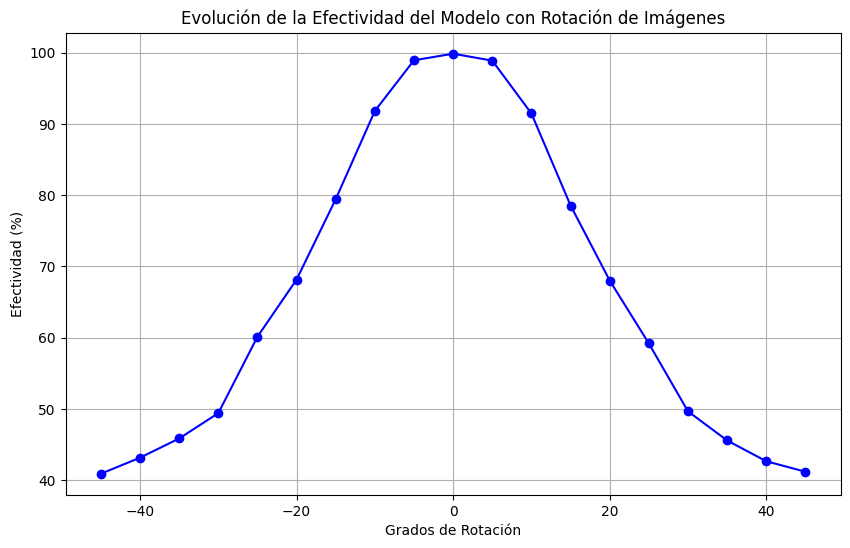

In [18]:
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

def rotar_grados(data_imgs, ang):
    result = np.empty_like(data_imgs)
    for i, img in enumerate(data_imgs):
        result[i] = rotate(img, ang, reshape=False, mode='reflect')
    return result

# Lista para almacenar los resultados de la efectividad
efectividades = []
grados_rotacion = []

for i in range(19):
    grados = -45 + i * 5
    x_test_rot = rotar_grados(x_test, grados)

    # Evalúa el modelo con los datos de prueba rotados
    pred = model_original.evaluate(x_test_rot, y_test, verbose=0)
    efectividad = pred[1] * 100
    print("Efectividad del modelo con datos de Prueba rotado %3d grados: %6.2f%%" % (grados, efectividad))

    # Almacena los resultados
    efectividades.append(efectividad)
    grados_rotacion.append(grados)

plt.figure(figsize=(10, 6))
plt.plot(grados_rotacion, efectividades, marker='o', linestyle='-', color='b')
plt.title('Evolución de la Efectividad del Modelo con Rotación de Imágenes')
plt.xlabel('Grados de Rotación')
plt.ylabel('Efectividad (%)')
plt.grid(True)
plt.show()

### c)

Genere una versión del **dataset train** como en b) y repita el entrenamiento y prueba del punto a) con los datasets modificados.


=== GENERANDO DATOS ROTADOS ===
Generando 5 rotaciones por imagen...
Procesando imagen 12501/12599
Datos aumentados: 75594 imágenes (original: 12599)

=== ENTRENAMIENTO CON DATOS ROTADOS ===
Entrenando modelo con 75594 imágenes
Forma de imagen: (64, 64, 1), Clases: 6


E0000 00:00:1760988193.021658  152769 meta_optimizer.cc:967] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/gradient_tape/sequential_4_1/conv2d_9_1/leaky_re_lu_4_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/sequential_4_1/conv2d_9_1/BiasAdd'.



Resultados del Datos con Rotaciones:
Efectividad entrenamiento: 100.00%%
Efectividad validación...: 100.00%%
Efectividad prueba.......: 100.00%%



=== COMPARACIÓN CON ROTACIONES EN TEST ===
Rotación -45° - Original: 40.92%, Rotado: 99.31%
Rotación -35° - Original: 45.86%, Rotado: 99.97%
Rotación -25° - Original: 60.14%, Rotado: 100.00%
Rotación -15° - Original: 79.44%, Rotado: 100.00%
Rotación  -5° - Original: 98.94%, Rotado: 100.00%
Rotación   5° - Original: 98.89%, Rotado: 99.97%
Rotación  15° - Original: 78.56%, Rotado: 100.00%
Rotación  25° - Original: 59.19%, Rotado: 100.00%
Rotación  35° - Original: 45.58%, Rotado: 99.94%
Rotación  45° - Original: 41.19%, Rotado: 98.72%


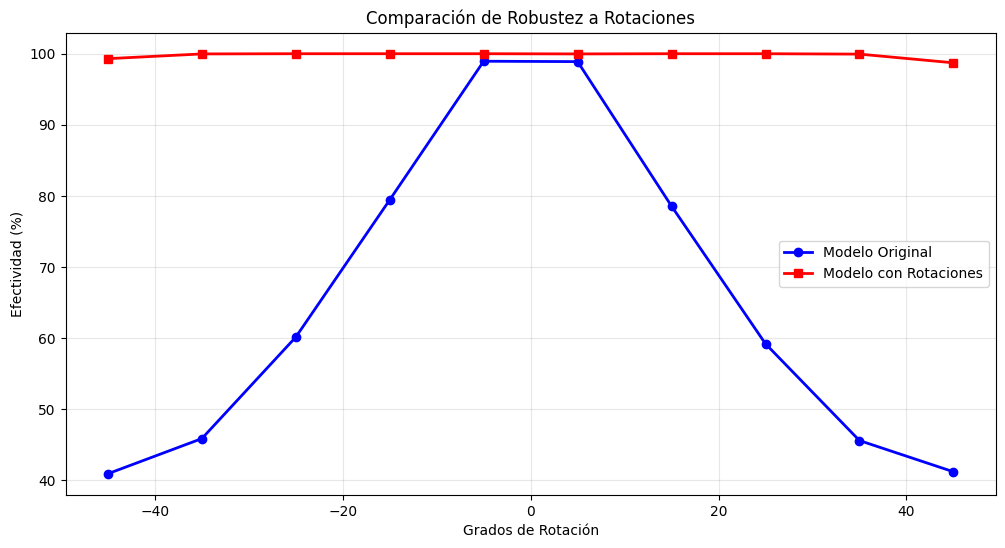

In [19]:
from scipy.ndimage import rotate
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, LeakyReLU
from tensorflow.keras import optimizers, callbacks
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

def generar_datos_rotados(x_data, y_data, min_grados=-45, max_grados=45, num_rotaciones=5):
    """
    Genera nuevas imágenes rotadas aleatoriamente
    
    Args:
        x_data: imágenes originales
        y_data: etiquetas originales
        min_grados: mínimo grado de rotación
        max_grados: máximo grado de rotación
        num_rotaciones: cantidad de rotaciones por imagen
    
    Returns:
        x_augmented, y_augmented: datos aumentados con rotaciones
    """
    x_rotated = []
    y_rotated = []
    
    print(f"Generando {num_rotaciones} rotaciones por imagen...")
    
    for i, (img, label) in enumerate(zip(x_data, y_data)):
        # Agregar imagen original
        x_rotated.append(img)
        y_rotated.append(label)
        
        # Generar rotaciones aleatorias
        for _ in range(num_rotaciones):
            angulo = np.random.uniform(min_grados, max_grados)
            img_rotada = rotate(img, angulo, reshape=False, mode='reflect')
            x_rotated.append(img_rotada)
            y_rotated.append(label)
        
        if i % 100 == 0:
            print(f"\rProcesando imagen {i+1}/{len(x_data)}", end="")
    
    print(f"\nDatos aumentados: {len(x_rotated)} imágenes (original: {len(x_data)})")
    
    return np.array(x_rotated), np.array(y_rotated)

# 2. Generar datos rotados
print("\n=== GENERANDO DATOS ROTADOS ===")
x_train_rotado, y_train_rotado = generar_datos_rotados(
    x_train, y_train, 
    min_grados=-45, max_grados=45, 
    num_rotaciones=5
)

# 3. Entrenar con datos rotados
print("\n=== ENTRENAMIENTO CON DATOS ROTADOS ===")
model_rotado, history_rotado = entrenar_modelo_cnn(
    x_train_rotado, y_train_rotado, x_test, y_test,
    titulo="Datos con Rotaciones"
)

# 4. Comparar rendimiento con rotaciones en test
print("\n=== COMPARACIÓN CON ROTACIONES EN TEST ===")
efectividades_orig = []
efectividades_rot = []
grados_test = []

for i in range(10):
    grados = -45 + i * 10
    x_test_rot = np.array([rotate(img, grados, reshape=False, mode='reflect') for img in x_test])
    
    # Evaluar ambos modelos
    pred_orig = model_original.evaluate(x_test_rot, y_test, verbose=0)
    pred_rot = model_rotado.evaluate(x_test_rot, y_test, verbose=0)
    
    efectividades_orig.append(pred_orig[1] * 100)
    efectividades_rot.append(pred_rot[1] * 100)
    grados_test.append(grados)
    
    print(f"Rotación {grados:3d}° - Original: {pred_orig[1]*100:.2f}%, Rotado: {pred_rot[1]*100:.2f}%")

# Gráfico comparativo
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(grados_test, efectividades_orig, 'b-o', label='Modelo Original', linewidth=2)
plt.plot(grados_test, efectividades_rot, 'r-s', label='Modelo con Rotaciones', linewidth=2)
plt.title('Comparación de Robustez a Rotaciones')
plt.xlabel('Grados de Rotación')
plt.ylabel('Efectividad (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()